In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Imports

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings

import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Input, Dropout, Lambda

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing



In [ ]:
# Load data =
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Moondash/moondash_data.xlsx', sheet_name='moondash_data')



# Data Preprocessing


### Here we are doing some simple data preprocesing. Since we are doing forecasting, we want to make sure all of our formats are aligned for time sequences algorithms. We also are forecasting for the next year, so we will break down by months.

In [ ]:
# Convert dates to datetime (preperation for forecasting)
df['effective_date'] = pd.to_datetime(df['effective_date'])
df['hire_date'] = pd.to_datetime(df['hire_date'])

# Setting time sequence frequency to months and setting index for hiring
hiring_ts = df.groupby(pd.Grouper(key='hire_date', freq='M')).size().reset_index()
hiring_ts.columns = ['date', 'hires']
hiring_ts.set_index('date', inplace=True)

# Setting time sequence frequency to months and setting index  for turnover
turnover_df = df[df['employee_status'] == 'Terminated'].copy()
turnover_ts = turnover_df.groupby(pd.Grouper(key='effective_date', freq='M')).size().reset_index()
turnover_ts.columns = ['date', 'turnover']
turnover_ts.set_index('date', inplace=True)



<ipython-input-4-bde6072473ed>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  hiring_ts = df.groupby(pd.Grouper(key='hire_date', freq='M')).size().reset_index()
<ipython-input-4-bde6072473ed>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  turnover_ts = turnover_df.groupby(pd.Grouper(key='effective_date', freq='M')).size().reset_index()


### Quick Sanity Check

In [ ]:
# Sanity check
print("Hiring Time Series:")
print(hiring_ts.head())
print("\nTurnover Time Series:")
print(turnover_ts.head())


Hiring Time Series:
            hires
date             
2018-01-31     87
2018-02-28     69
2018-03-31     33
2018-04-30    118
2018-05-31     89

Turnover Time Series:
            turnover
date                
2022-03-31       920
2022-04-30         0
2022-05-31         0
2022-06-30      1094
2022-07-31         0


# Model Building


## I use the following four models:

1.   Model 1: Long Short-Term Memory (LSTM)
  - Recurrent neural network (RNN) designed to handle sequential data by capturing long-term dependencies
2.   Model 2: Seasonal AutoRegressive Integrated Moving Average with Exogenous Regressors (SARIMAX)
  - Statistical model for time series forecasting that combines three components AutoRegression, Differencing, Seasonality, Exogenous Regressors and Moving Average
  - This is a more specalized version of the common ARIMA model and is often called the Seasonal ARIMA model. We will just refer to this as ARIMA throughout the experiment
3.   Model 3: Exponential Smoothing (Holt-Winters Method)
  -  Statistical time series forecasting model that assigns exponentially decreasing weights to past observations that perfoms well with seasonal variations and trends
4.   Model 4: Temporal Convolutional Network (TCN)
  - Deep learning-based approach which use Dilated Convolutions as opposed to sequential depencies like LSTM




### Below is the actual building of these models. I put TCN in a seperate section, since the code is more complicated and I wanted to keep things clean. Below is the forecasting for only hiring.

In [ ]:
### Hiring Forecasts
############################

#LSTM Model
scaler_hiring = MinMaxScaler()
hiring_scaled = scaler_hiring.fit_transform(hiring_ts['hires'].values.reshape(-1, 1))

# Prepare sequences for LSTM
X_hiring = []
y_hiring = []
n_steps = 30
for i in range(len(hiring_scaled) - n_steps):
    X_hiring.append(hiring_scaled[i:(i + n_steps)])
    y_hiring.append(hiring_scaled[i + n_steps])

X_hiring = np.array(X_hiring)
y_hiring = np.array(y_hiring)
X_hiring = X_hiring.reshape((X_hiring.shape[0], X_hiring.shape[1], 1))

# Create and train LSTM model
lstm_hiring = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, 1)),
    Dense(1)
])
lstm_hiring.compile(optimizer='adam', loss='mse')
lstm_hiring.fit(X_hiring, y_hiring, epochs=100, batch_size=32, verbose=0)

# Generate LSTM forecasts
last_sequence_hiring = hiring_scaled[-n_steps:]
lstm_hiring_forecast = []

for _ in range(12):  # 12 months forecast
    next_pred = lstm_hiring.predict(last_sequence_hiring.reshape(1, n_steps, 1), verbose=0)
    lstm_hiring_forecast.append(next_pred[0, 0])
    last_sequence_hiring = np.roll(last_sequence_hiring, -1)
    last_sequence_hiring[-1] = next_pred

lstm_hiring_forecast = scaler_hiring.inverse_transform(np.array(lstm_hiring_forecast).reshape(-1, 1)) # Save the forecast predictions for later


############################
# Exponential Smoothing Model

exp_hiring = ExponentialSmoothing(
    hiring_ts['hires'],
    seasonal_periods=12,
    trend='add',
    seasonal='add'
).fit()
exp_hiring_forecast = exp_hiring.forecast(12)

############################
# ARIMA Model

arima_hiring = SARIMAX(
    hiring_ts['hires'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12)
).fit()
arima_hiring_forecast = arima_hiring.forecast(12)



#Create Dataframe
forecast_dates = pd.date_range(start='2025-01-01', periods=12, freq='M')


hiring_forecasts = pd.DataFrame({
    'Date': forecast_dates,
    'LSTM': lstm_hiring_forecast.flatten(),
    'Exponential_Smoothing': exp_hiring_forecast.values,
    'ARIMA': arima_hiring_forecast.values
})




/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
<ipython-input-32-28b8ebe058c0>:68: FutureWarning: 'M' is deprecated and will be removed in a future vers

### In the following section, we will start forecasting for Turnover. The same code and methodology from above is used below for calculating the forecasts of Turnover.

In [ ]:
### Turnover Forecasts
############################

#LSTM Model
scaler_turnover = MinMaxScaler()
turnover_scaled = scaler_turnover.fit_transform(turnover_ts['turnover'].values.reshape(-1, 1))

# Prepare sequences for LSTM
X_turnover = []
y_turnover = []
n_steps = 30
for i in range(len(turnover_scaled) - n_steps):
    X_turnover.append(turnover_scaled[i:(i + n_steps)])
    y_turnover.append(turnover_scaled[i + n_steps])

X_turnover = np.array(X_turnover)
y_turnover = np.array(y_turnover)
X_turnover = X_turnover.reshape((X_turnover.shape[0], X_turnover.shape[1], 1))

# Create and train LSTM model
lstm_turnover = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, 1)),
    Dense(1)
])
lstm_turnover.compile(optimizer='adam', loss='mse')
lstm_turnover.fit(X_turnover, y_turnover, epochs=100, batch_size=32, verbose=0)

# Generate LSTM forecasts
last_sequence_turnover = turnover_scaled[-n_steps:]
lstm_turnover_forecast = []

for _ in range(12):
    next_pred = lstm_turnover.predict(last_sequence_turnover.reshape(1, n_steps, 1), verbose=0)
    lstm_turnover_forecast.append(next_pred[0, 0])
    last_sequence_turnover = np.roll(last_sequence_turnover, -1)
    last_sequence_turnover[-1] = next_pred

lstm_turnover_forecast = scaler_turnover.inverse_transform(np.array(lstm_turnover_forecast).reshape(-1, 1))

############################
# Exponential Smoothing Model

exp_turnover = ExponentialSmoothing(
    turnover_ts['turnover'],
    seasonal_periods=12,
    trend='add',
    seasonal='add'
).fit()
exp_turnover_forecast = exp_turnover.forecast(12)


############################
# Arima Model

arima_turnover = SARIMAX(
    turnover_ts['turnover'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12)
).fit()
arima_turnover_forecast = arima_turnover.forecast(12)

#Create Dataframe

turnover_forecasts = pd.DataFrame({
    'Date': forecast_dates, #Reusuing forecast dates from above chunk
    'LSTM': lstm_turnover_forecast.flatten(),
    'Exponential_Smoothing': exp_turnover_forecast.values,
    'ARIMA': arima_turnover_forecast.values
})


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few o

## In this section, I build out the Temporal Convolutional Network (TCN). I keep hiring and turnover in the same section unlike above.


In [ ]:
#Temporal Convolutional Network


#Defining TCN architecture block function

def tcn_block(input_layer, filters, kernel_size, dilation_rate):
    padding = (kernel_size - 1) * dilation_rate #Calculate amount of padding needed for causal convolutions
    padded_input = Lambda(lambda x: tf.pad(x, [[0, 0], [padding, 0], [0, 0]]))(input_layer) #Applying calculated padding from above

    # Apply dilated causal convolution
    conv = Conv1D(filters=filters,
                 kernel_size=kernel_size,
                 dilation_rate=dilation_rate,
                 padding='valid',
                 activation='relu')(padded_input)

    conv = Dropout(0.2)(conv)
    if input_layer.shape[-1] != filters:  # Makes sure input layer has the same number of filters as conv layer for residual connection
        input_layer = Conv1D(filters=filters, kernel_size=1)(input_layer)

    return Lambda(lambda x: x[0] + x[1])([input_layer, conv])


##Creating Architecture for TCN using above function
input_layer = Input(shape=(n_steps, 1))
x = input_layer

# Stacking TCN blocks with increasing dilation rates
filters = 64
kernel_size = 3
for dilation_rate in [1, 2, 4, 8]:
    x = tcn_block(x, filters, kernel_size, dilation_rate)

# Final output layer
x = Dense(32, activation='relu')(x)
output_layer = Dense(1)(x)


###########################
# TCN Model for Hiring:
###########################


# Create and compile model
tcn_hiring = Model(inputs=input_layer, outputs=output_layer)
tcn_hiring.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse')

# Train model
history_hiring = tcn_hiring.fit(X_hiring, y_hiring,
                              epochs=100,
                              batch_size=32,
                              validation_split=0.2,
                              verbose=1)

# Generate TCN forecast for hiring
last_sequence = hiring_scaled[-n_steps:]
tcn_hiring_forecast = []

#Retrieve Forecasts
for _ in range(12):
    current_pred = tcn_hiring.predict(last_sequence.reshape(1, n_steps, 1), verbose=0)
    tcn_hiring_forecast.append(current_pred[0, -1])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = current_pred[0, -1]

#Save Forecasts in clean format
tcn_hiring_forecast = scaler_hiring.inverse_transform(
    np.array(tcn_hiring_forecast).reshape(-1, 1))




###########################
# TCN Model for Turnover:
###########################

# Create and compile model
tcn_turnover = Model(inputs=input_layer, outputs=output_layer)
tcn_turnover.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='mse')

# Train model
history_turnover = tcn_turnover.fit(X_turnover, y_turnover,
                                   epochs=100,
                                   batch_size=32,
                                   validation_split=0.2,
                                   verbose=1)

# Generate TCN forecast for turnover
last_sequence = turnover_scaled[-n_steps:]
tcn_turnover_forecast = []

#Retrieve Forecasts
for _ in range(12):
    current_pred = tcn_turnover.predict(last_sequence.reshape(1, n_steps, 1), verbose=0)
    tcn_turnover_forecast.append(current_pred[0, -1])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = current_pred[0, -1]

#Save Forecasts in clean format
tcn_turnover_forecast = scaler_turnover.inverse_transform(
    np.array(tcn_turnover_forecast).reshape(-1, 1))




Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 406ms/step - loss: 0.0622 - val_loss: 0.0548
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0403 - val_loss: 0.0884
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0412 - val_loss: 0.0984
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0442 - val_loss: 0.0790
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0359 - val_loss: 0.0649
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0316 - val_loss: 0.0557
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0427 - val_loss: 0.0539
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0376 - val_loss: 0.0532
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0310 - val_loss: 0.0545
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0371 - val_loss: 0.0576
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0380 - val_loss: 0.0603
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0393 - val_l

# Model Evaluation

### Below, we will look at metrics for each of the forecasting models that were created. The main metric we will look at here is RMSE.

In [ ]:

print("=" * 50)
print("Hiring and Turnover Forecasts for 2025")
print("=" * 50)

print("\nHiring Forecasts for 2025:")
print(hiring_forecasts.round(0))

print("\nTurnover Forecasts for 2025:")
print(turnover_forecasts.round(0))

#### Model Performance Metrics ####
print("\n" + "=" * 50)
print("Model Performance Metrics")
print("=" * 50)



#### Hiring Metrics ####
print("\nHiring Model Performance:")
actual_hiring = hiring_ts['hires'].values[-12:]

mse = mean_squared_error(actual_hiring, lstm_hiring_forecast[:12])
print(f"LSTM RMSE: {math.sqrt(mse):.2f}")

mse = mean_squared_error(actual_hiring, exp_hiring_forecast[:12])
print(f"Exponential Smoothing RMSE: {math.sqrt(mse):.2f}")

mse = mean_squared_error(actual_hiring, arima_hiring_forecast[:12])
print(f"ARIMA RMSE: {math.sqrt(mse):.2f}")

mse = mean_squared_error(actual_hiring, tcn_hiring_forecast[:12])
print(f"TCN RMSE: {math.sqrt(mse):.2f}")


#### Turnover Metrics ####
print("\nTurnover Model Performance:")
actual_turnover = turnover_ts['turnover'].values[-12:]

mse = mean_squared_error(actual_turnover, lstm_turnover_forecast[:12])
print(f"LSTM RMSE: {math.sqrt(mse):.2f}")

mse = mean_squared_error(actual_turnover, exp_turnover_forecast[:12])
print(f"Exponential Smoothing RMSE: {math.sqrt(mse):.2f}")

mse = mean_squared_error(actual_turnover, arima_turnover_forecast[:12])
print(f"ARIMA RMSE: {math.sqrt(mse):.2f}")

mse = mean_squared_error(actual_turnover, tcn_turnover_forecast[:12])
print(f"TCN RMSE: {math.sqrt(mse):.2f}")




Hiring and Turnover Forecasts for 2025

Hiring Forecasts for 2025:
         Date    LSTM  Exponential_Smoothing   ARIMA     TCN
0  2025-01-31  1309.0                   18.0    69.0   741.0
1  2025-02-28  1093.0                   41.0  -223.0   792.0
2  2025-03-31  1123.0                 5329.0  4472.0  2464.0
3  2025-04-30  1145.0                   -3.0  -174.0   587.0
4  2025-05-31  1113.0                   14.0  -175.0   936.0
5  2025-06-30  1112.0                 3150.0  2593.0  1393.0
6  2025-07-31  1140.0                   46.0  -168.0   649.0
7  2025-08-31  1113.0                   63.0  -170.0   680.0
8  2025-09-30  1111.0                 3014.0  2363.0  1492.0
9  2025-10-31  1176.0                  111.0  -165.0   958.0
10 2025-11-30  1137.0                  126.0  -165.0   731.0
11 2025-12-31  1135.0                 3451.0  1462.0  1079.0

Turnover Forecasts for 2025:
         Date    LSTM  Exponential_Smoothing   ARIMA     TCN
0  2025-01-31   495.0                   58.0   -3

### Below, we will look at additional metrics like MAE and R^2 score

In [ ]:
metrics_data = []

# Function to compute model metrics
def compute_metrics(actual, predicted, model_name, category):
    mse = mean_squared_error(actual, predicted)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    metrics_data.append([model_name, category, rmse, mae, r2])

# Hiring Metrics (using function defined above)
compute_metrics(hiring_ts['hires'].values[-12:], lstm_hiring_forecast[:12], "LSTM", "Hiring")
compute_metrics(hiring_ts['hires'].values[-12:], exp_hiring_forecast[:12], "Exponential Smoothing", "Hiring")
compute_metrics(hiring_ts['hires'].values[-12:], arima_hiring_forecast[:12], "ARIMA", "Hiring")
compute_metrics(hiring_ts['hires'].values[-12:], tcn_hiring_forecast[:12], "TCN", "Hiring")

# Turnover Metrics (using function defined above)
compute_metrics(turnover_ts['turnover'].values[-12:], lstm_turnover_forecast[:12], "LSTM", "Turnover")
compute_metrics(turnover_ts['turnover'].values[-12:], exp_turnover_forecast[:12], "Exponential Smoothing", "Turnover")
compute_metrics(turnover_ts['turnover'].values[-12:], arima_turnover_forecast[:12], "ARIMA", "Turnover")
compute_metrics(turnover_ts['turnover'].values[-12:], tcn_turnover_forecast[:12], "TCN", "Turnover")


#Creating Dataframe
metrics_df = pd.DataFrame(metrics_data, columns=["Model", "Category", "RMSE", "MAE", "R2 Score"])
display(metrics_df)



,Model,Category,RMSE,MAE,R2 Score
0,LSTM,Hiring,1659.884183,1304.661987,0.032300
1,Exponential Smoothing,Hiring,646.628706,295.400137,0.853143
2,ARIMA,Hiring,345.510698,240.833127,0.958072
3,TCN,Hiring,1199.917653,985.479187,0.494306
4,LSTM,Turnover,2465.692296,1613.628418,-14.069416
5,Exponential Smoothing,Turnover,61.784331,60.840527,0.990538
6,ARIMA,Turnover,81.751640,54.459901,0.983434
7,TCN,Turnover,543.536711,381.313354,0.267721


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

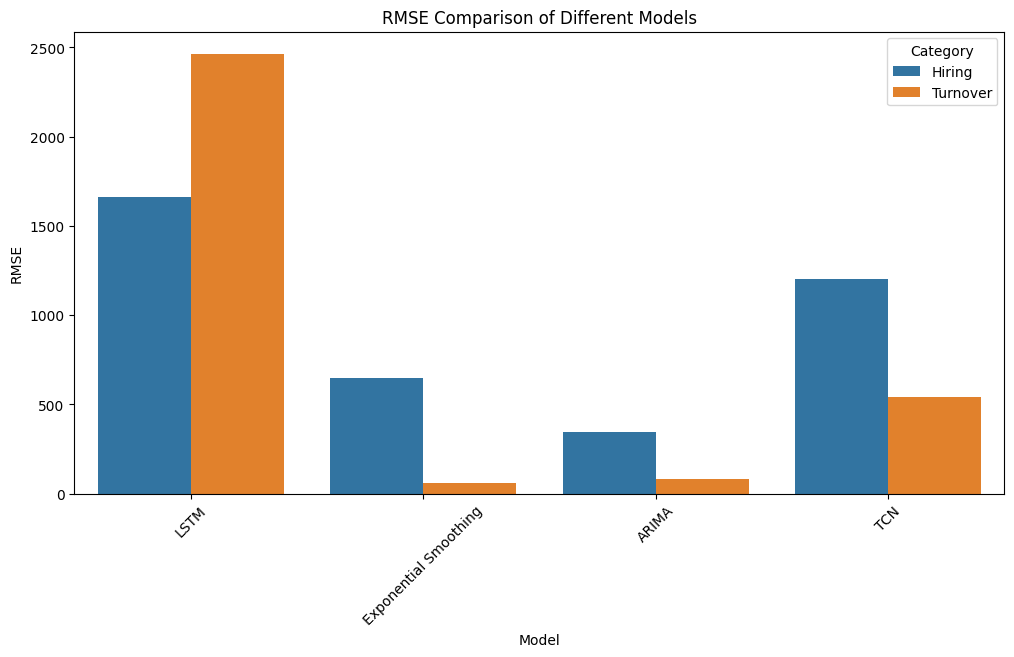

In [ ]:
# Visualization of RMSE
plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df, x="Model", y="RMSE", hue="Category")
plt.title("RMSE Comparison of Different Models")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt


# Visualizations

### It looks like the Exponeential Smoothing and ARIMA models performed much better than the rest of the models.

### Now that we already calculated all of our forecasts for ARIMA, Exponential Smoothing, LSTM, and TCN, and we have a sense of which models tend to perform better lets visualize the forecasts:

<ipython-input-52-b88b11f04d3b>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates_2025 = pd.date_range(start=last_date, periods=13, freq='M')[1:]


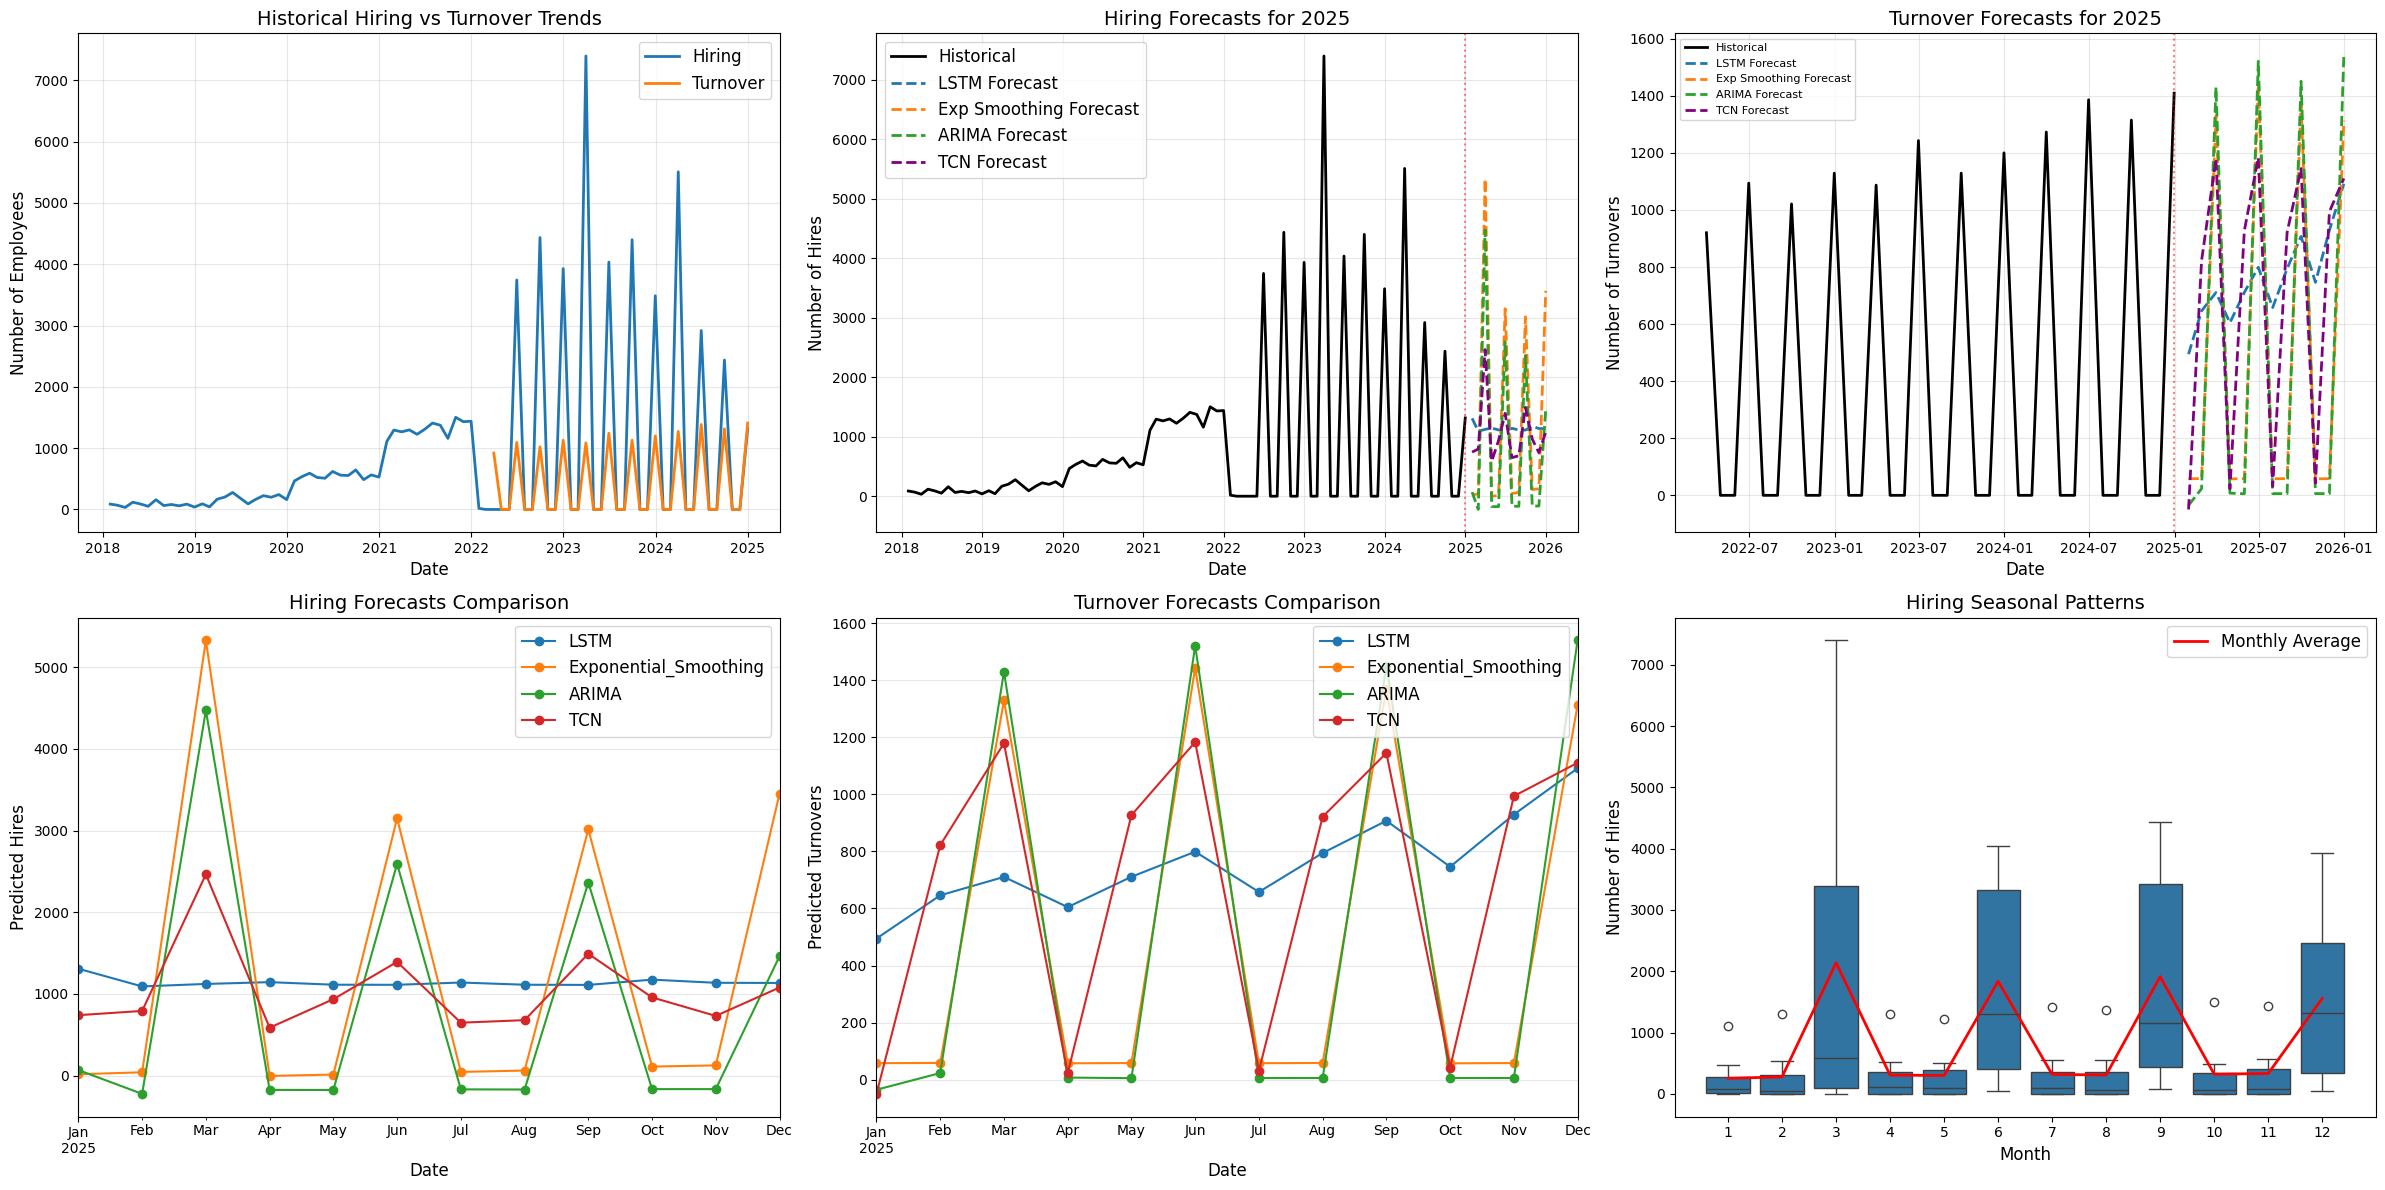

In [ ]:


#Figure size + plotting template
plt.rcParams['figure.figsize'] = (18, 8)
fig, axes = plt.subplots(2, 3, figsize=(24, 12))


# Dates to connect historical data with forecasts
last_date = hiring_ts.index[-1]
dates_2025 = pd.date_range(start=last_date, periods=13, freq='M')[1:]



######################################################
#  Plot 1, Historical Hiring vs Turnover:
######################################################
axes[0, 0].plot(hiring_ts.index, hiring_ts['hires'], label='Hiring', linewidth=2)
axes[0, 0].plot(turnover_ts.index, turnover_ts['turnover'], label='Turnover', linewidth=2)
axes[0, 0].set_title('Historical Hiring vs Turnover Trends', fontsize=14)
axes[0, 0].set_xlabel('Date', fontsize=12)
axes[0, 0].set_ylabel('Number of Employees', fontsize=12)
axes[0, 0].legend(fontsize=12)
axes[0, 0].grid(True, alpha=0.3)


######################################################
#  Plot 2, Hiring Forecasts:
######################################################
axes[0, 1].plot(hiring_ts.index, hiring_ts['hires'], label='Historical', linewidth=2, color='black')
axes[0, 1].plot(dates_2025, lstm_hiring_forecast, label='LSTM Forecast', linewidth=2, linestyle='--')
axes[0, 1].plot(dates_2025, exp_hiring_forecast, label='Exp Smoothing Forecast', linewidth=2, linestyle='--')
axes[0, 1].plot(dates_2025, arima_hiring_forecast, label='ARIMA Forecast', linewidth=2, linestyle='--')
axes[0, 1].plot(dates_2025, tcn_hiring_forecast, label='TCN Forecast', linewidth=2, linestyle='--', color='purple')
axes[0, 1].axvline(x=last_date, color='red', linestyle=':', alpha=0.5)
axes[0, 1].set_title('Hiring Forecasts for 2025', fontsize=14)
axes[0, 1].set_xlabel('Date', fontsize=12)
axes[0, 1].set_ylabel('Number of Hires', fontsize=12)
axes[0, 1].legend(fontsize=12)
axes[0, 1].grid(True, alpha=0.3)


######################################################
#  Plot 3, Turnover Forecasts:
######################################################

axes[0, 2].plot(turnover_ts.index, turnover_ts['turnover'], label='Historical', linewidth=2, color='black')
axes[0, 2].plot(dates_2025, lstm_turnover_forecast, label='LSTM Forecast', linewidth=2, linestyle='--')
axes[0, 2].plot(dates_2025, exp_turnover_forecast, label='Exp Smoothing Forecast', linewidth=2, linestyle='--')
axes[0, 2].plot(dates_2025, arima_turnover_forecast, label='ARIMA Forecast', linewidth=2, linestyle='--')
axes[0, 2].plot(dates_2025, tcn_turnover_forecast, label='TCN Forecast', linewidth=2, linestyle='--', color='purple')
axes[0, 2].axvline(x=last_date, color='red', linestyle=':', alpha=0.5)
axes[0, 2].set_title('Turnover Forecasts for 2025', fontsize=14)
axes[0, 2].set_xlabel('Date', fontsize=12)
axes[0, 2].set_ylabel('Number of Turnovers', fontsize=12)
axes[0, 2].legend(fontsize=8)
axes[0, 2].grid(True, alpha=0.3)


######################################################
#  Plot 4,  Hiring Forecasts Comparison:
######################################################
hiring_forecasts["TCN"] = tcn_hiring_forecast.flatten()
hiring_forecasts.plot(x='Date', y=['LSTM', 'Exponential_Smoothing', 'ARIMA', 'TCN'], ax=axes[1, 0], marker='o')
axes[1, 0].set_title('Hiring Forecasts Comparison', fontsize=14)
axes[1, 0].set_xlabel('Date', fontsize=12)
axes[1, 0].set_ylabel('Predicted Hires', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(fontsize=12)

######################################################
#  Plot 5, Turnover Forecasts Comparison:
######################################################
turnover_forecasts["TCN"] = tcn_turnover_forecast.flatten()
turnover_forecasts.plot(x='Date', y=['LSTM', 'Exponential_Smoothing', 'ARIMA', 'TCN'], ax=axes[1, 1], marker='o')
axes[1, 1].set_title('Turnover Forecasts Comparison', fontsize=14)
axes[1, 1].set_xlabel('Date', fontsize=12)
axes[1, 1].set_ylabel('Predicted Turnovers', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend(fontsize=12)

######################################################
#  Plot 6, Hiring & Turnover Seasonal Patterns:
######################################################
hiring_ts['Month'] = hiring_ts.index.month
monthly_hiring_avg = hiring_ts.groupby('Month')['hires'].mean()

sns.boxplot(data=hiring_ts, x='Month', y='hires', ax=axes[1, 2])
axes[1, 2].plot(range(12), monthly_hiring_avg.values, 'r-', linewidth=2, label='Monthly Average')
axes[1, 2].set_title('Hiring Seasonal Patterns', fontsize=14)
axes[1, 2].set_xlabel('Month', fontsize=12)
axes[1, 2].set_ylabel('Number of Hires', fontsize=12)
axes[1, 2].legend(fontsize=12)

plt.tight_layout()
plt.show()


### Now let's take a look at a Model Agreement Analysis, a technique used to evaluate the consistency and variability of predictions across all of the models. By comparing the forecasts, we can assess how much they align, identify areas of uncertainty, and improve the reliability of the predictions.


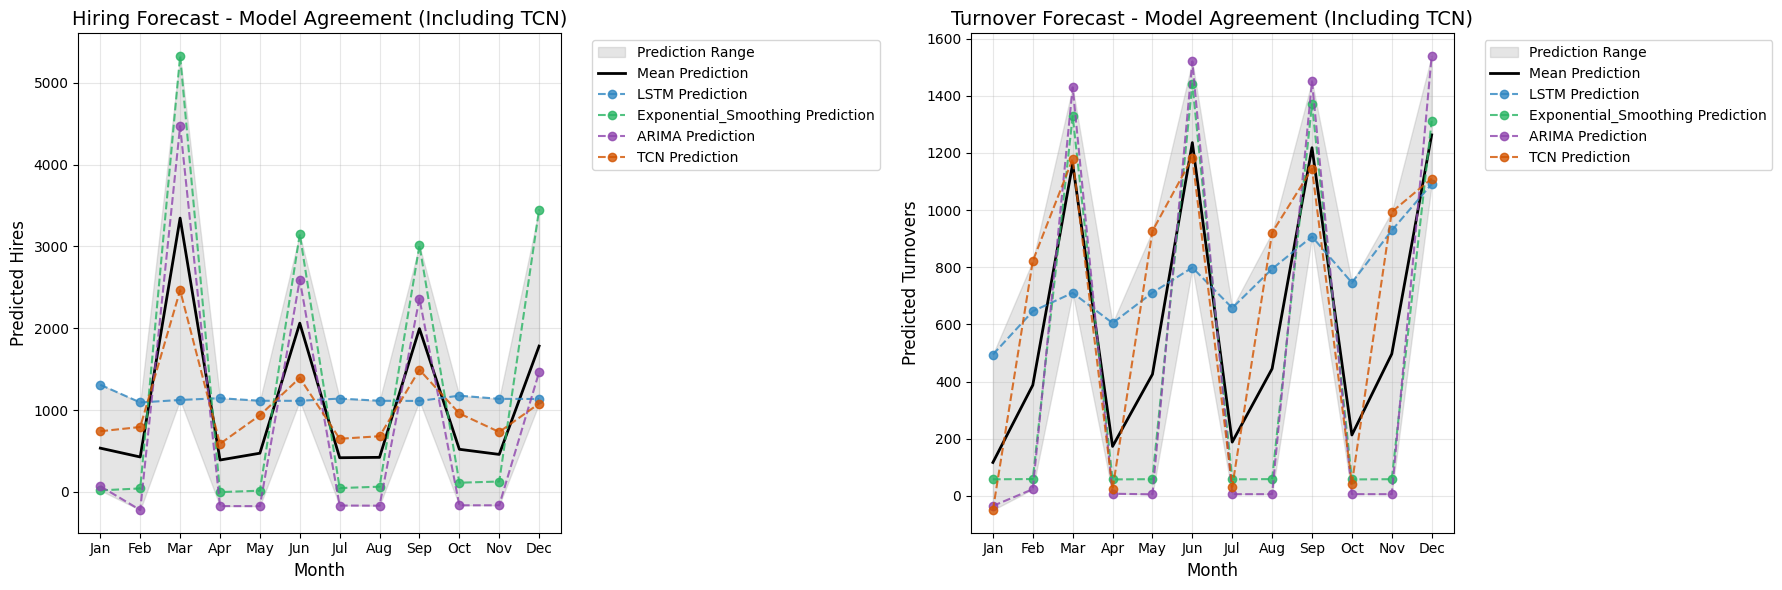

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns

# Setting colors for models (Blue, Green, Purple, and Orange in that order)
model_colors = {
    'LSTM': '#2E86C1',
    'Exponential_Smoothing': '#28B463',
    'ARIMA': '#8E44AD',
    'TCN': '#D35400'
}

# Calculate range of predictions for each month for hiring
hiring_range = pd.DataFrame({
    'Date': forecast_dates,
    'Min': hiring_forecasts[['LSTM', 'Exponential_Smoothing', 'ARIMA', 'TCN']].min(axis=1),
    'Max': hiring_forecasts[['LSTM', 'Exponential_Smoothing', 'ARIMA', 'TCN']].max(axis=1),
    'Mean': hiring_forecasts[['LSTM', 'Exponential_Smoothing', 'ARIMA', 'TCN']].mean(axis=1)
})

# Calculate range of predictions for each month for turnover
turnover_range = pd.DataFrame({
    'Date': forecast_dates,
    'Min': turnover_forecasts[['LSTM', 'Exponential_Smoothing', 'ARIMA', 'TCN']].min(axis=1),
    'Max': turnover_forecasts[['LSTM', 'Exponential_Smoothing', 'ARIMA', 'TCN']].max(axis=1),
    'Mean': turnover_forecasts[['LSTM', 'Exponential_Smoothing', 'ARIMA', 'TCN']].mean(axis=1)
})

# Convert forecast_dates to month names
hiring_range['Month'] = hiring_range['Date'].dt.strftime('%b')
turnover_range['Month'] = turnover_range['Date'].dt.strftime('%b')

#Create plotting template
fig, axes = plt.subplots(1, 2, figsize=(18, 6))


######################################################
#  Hiring Plot:
######################################################
axes[0].fill_between(hiring_range['Month'],
                     hiring_range['Min'],
                     hiring_range['Max'],
                     alpha=0.2, color='gray', label='Prediction Range')
axes[0].plot(hiring_range['Month'], hiring_range['Mean'], 'k-',
             label='Mean Prediction', linewidth=2)

# Individual model predictions for hiring
for model in model_colors.keys():
    axes[0].plot(hiring_range['Month'],
                 hiring_forecasts[model],
                 'o--',
                 color=model_colors[model],
                 alpha=0.8,
                 label=f'{model} Prediction',
                 linewidth=1.5)

axes[0].set_title('Hiring Forecast - Model Agreement', fontsize=14)
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Predicted Hires', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')



######################################################
#  Turnover Plot:
######################################################
axes[1].fill_between(turnover_range['Month'],
                     turnover_range['Min'],
                     turnover_range['Max'],
                     alpha=0.2, color='gray', label='Prediction Range')
axes[1].plot(turnover_range['Month'], turnover_range['Mean'], 'k-',
             label='Mean Prediction', linewidth=2)

# Add individual model predictions for turnover
for model in model_colors.keys():
    axes[1].plot(turnover_range['Month'],
                 turnover_forecasts[model],
                 'o--',
                 color=model_colors[model],
                 alpha=0.8,
                 label=f'{model} Prediction',
                 linewidth=1.5)

axes[1].set_title('Turnover Forecast - Model Agreement', fontsize=14)
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Predicted Turnovers', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [ ]:
#Hiring stats

monthly_stats = pd.DataFrame({
    'Month': hiring_range['Month'],
    'Avg Hiring': hiring_range['Mean'].round(1),
    'Hiring Range': (hiring_range['Max'] - hiring_range['Min']).round(1),
    'Hiring Std Dev': hiring_forecasts[['LSTM', 'Exponential_Smoothing', 'ARIMA', 'TCN']].std(axis=1).round(1),
    'Avg Turnover': turnover_range['Mean'].round(1),
    'Turnover Range': (turnover_range['Max'] - turnover_range['Min']).round(1),
    'Turnover Std Dev': turnover_forecasts[['LSTM', 'Exponential_Smoothing', 'ARIMA', 'TCN']].std(axis=1).round(1),
    'Avg Net Change': (hiring_range['Mean'] - turnover_range['Mean']).round(1)
})



display(monthly_stats)

,Month,Avg Hiring,Hiring Range,Hiring Std Dev,Avg Turnover,Turnover Range,Turnover Std Dev,Avg Net Change
0,Jan,533.9,1291.2,612.8,117.0,544.1,256.2,416.8
1,Feb,425.9,1315.1,618.4,387.6,798.5,406.7,38.3
2,Mar,3347.0,4205.7,1907.8,1162.1,719.3,318.2,2184.8
3,Apr,388.6,1319.2,600.6,173.2,597.3,288.5,215.4
4,May,472.0,1288.7,647.1,425.5,921.5,463.4,46.5
5,Jun,2062.0,2037.5,968.8,1236.4,721.6,325.2,825.7
6,Jul,416.7,1308.1,593.5,188.3,651.9,313.8,228.5
7,Aug,421.5,1282.8,584.0,445.2,915.2,479.9,-23.6
8,Sep,1995.1,1902.8,858.0,1218.5,543.6,244.6,776.6
9,Oct,520.1,1340.4,647.5,213.2,740.1,356.0,306.9


## Key Insights from Forecast Visualizations and Hiring Stats


*   It seems like a structured hiring cycle. There sharp peaks in March, June,September, and December, confirming that hiring might follow a quarterly recruitment pattern.
  - In the dataframe above, March has the highest hiring average (3347 hires), followed by June (2062), September (1995), and December (1781).

*   It also seems like hiring slows down a lot in April, July, and October.

*   Forecasts in the earlier graphs show large fluctuations in hiring numbers, meaning that while there is a cyclical pattern hiring volumes might still be unpredictable.
*   The earlier graphs showed big swings in hiring numbers. It looks like there is a pattern, but the exact number of hires each month is still unpredictable and could change based on different factors.

*   Turnover seems to follow the same cycle as hiring. The biggest spikes in people leaving happen in the same months that hiring goes up. This could also mean that Moondash could be replacing employees.
*   Turnover doesn’t drop to zero, meaning people are still leaving throughout the year.
*   If hiring is higher than turnover in certain months, companies might end up with more employees overall.
*  The overall hiring and turnover trends suggest that companies are focused on maintaining staff levels rather than growing significantly.
